### Clustering and run MCMC
Since we have too many parameter to optimize, and we only have limited observations. Due to the curse of dimensionality, we decided to reduce our dimensions. We grouped our players into 20 groups and optimize those 40 parameters. 


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
import pickle

/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Clustering 

In [2]:
game16_df = pd.read_csv('clean-data/game_outcomes_15-16.csv')
player_info = pd.read_csv('clean-data/player_info_pergame.csv')

In [3]:
player_info["off_rating"] = player_info['PTS'].values + player_info['AST'].values
player_info["def_rating"] = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [6]:
player_val = player_info[['off_rating','def_rating']]

In [7]:
df_norm = (player_val - player_val.mean(axis = 0))/ player_val.std(axis = 0)
df_norm = df_norm.fillna(0)

In [9]:
from sklearn import cluster
k_means = cluster.KMeans(init = "k-means++",n_clusters=20)
k_means_clusters = k_means.fit_predict(df_norm.values) 


In [59]:
score_diff = game16_df['diff'].values

### Run MCMC 

In [12]:
# import the pickle files for guest/host teams line_up
with open('clean-data/guest_team_line_up.pkl', 'rb') as handle:
    guest_team_line_up = pickle.load(handle)
with open('clean-data/host_team_line_up.pkl','rb') as handle:
    host_team_line_up = pickle.load(handle)

In [13]:
def make_guest_host_mat(game_outcomes_df):
    '''
    Makes a matrix for guests and hosts. Each row of each
    matrix corresponds to one matchup. All elements of each row
    are zero except the ith one (different for each row).
    For the guest matrix, the ith entry in row j means that in game j,
    the guest team was team i. In the host matrix, the ith entry in
    row j means that the host team was team i
    '''
    
    def make_matrix(mat, indices):
        '''given a matrix and indices, sets the right one in each row
        to be true'''
        for (i, ind) in enumerate(indices):
            mat[i, ind] = True
        
    nrows = game_outcomes_df.shape[0]
    ncols = np.max(game_outcomes_df['Visitor_Index'] + 1)
    
    guest_matrix = np.zeros((nrows, ncols), dtype = bool)
    host_matrix = np.zeros((nrows, ncols), dtype = bool)
    
    make_matrix(guest_matrix, game_outcomes_df['Visitor_Index'].values)
    make_matrix(host_matrix, game_outcomes_df['Home_Index'].values)
    
    return(guest_matrix, host_matrix)

In [14]:
guest_matrix, host_matrix = make_guest_host_mat(game16_df)

In [15]:
# Copy the variables from Andy's part
guest_lineup_arr = np.array(guest_team_line_up)
host_lineup_arr = np.array(host_team_line_up)
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [16]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams),))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):]
    
    # parameterize sigma by its log
    #logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    
    return (beta0, beta_player, gamma0, gamma_player)#, logsigma)

In [17]:
# Construct beta and gamma 
team_num = 30
param_num = 20
coefs = pm.MvNormalCov("coefs", mu = np.zeros(2*(team_num + param_num)),
                      C = np.eye(2*(team_num + param_num)))
tau = pm.Gamma("tau", alpha = 2, beta = 2)

In [35]:
# construct new cluster label matrix
# k_means_clusters.shape
players_labels = []
cluster_num = 20
for i in range(k_means_clusters.shape[0]):
    new_labels = np.array([0] * cluster_num)
    new_labels[k_means_clusters[i]] = 1
    players_labels.append(new_labels)

In [53]:
players_labels_arr = np.array(players_labels)
host_clusters = np.dot(host_lineup_arr,players_labels_arr)
guest_clusters = np.dot(guest_lineup_arr,players_labels_arr)

In [56]:
# K-Means Mean Values
off_rating_means = k_means.cluster_centers_[:,0]
def_rating_means = k_means.cluster_centers_[:,1]


In [60]:
# Use a different log-likelihood
@pm.observed(name = "loglik", observed = True)
def loglik(coefs = coefs, tau = tau, value = score_diff, 
            off_rating = off_rating_means, def_rating = def_rating_means, 
            nplayers = cluster_num, nteams = team_num,
            guest_matrix = guest_matrix, host_matrix = host_matrix, guest_lineup_arr = guest_clusters,
            host_lineup_arr = host_clusters):

    beta0, betas, gamma0, gammas = \
             split_params(coefs, nplayers, nteams)
    
    ngames = value.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = pm.normal_like(value, mean, tau)
    return(loglik)

In [61]:
parameterlist = [loglik, coefs, tau]
response_model=pm.Model(parameterlist)

In [62]:
mcmc = pm.MCMC(response_model)

In [71]:
mcmc.sample(iter=30000, burn = 100, thin = 1)

 [-----------------100%-----------------] 30000 of 30000 complete in 33.3 sec

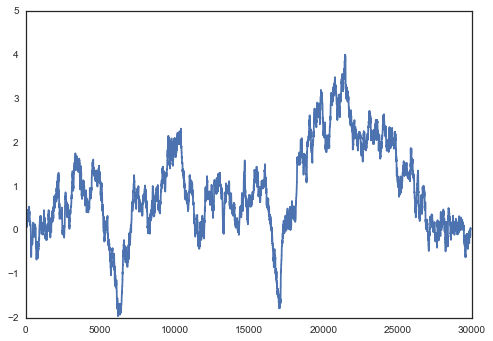

In [72]:
plt.plot(coefs.trace()[:, 70])

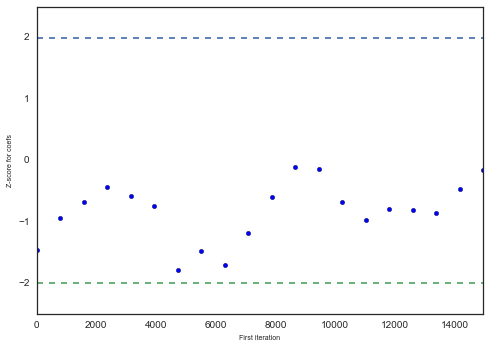

In [77]:
geweke_res = pm.geweke(coefs.trace()[:,70])
pm.Matplot.geweke_plot(geweke_res,'coefs')

